### Example on Echo State Networks (ESNs)

This notebook covers the first systematic view an basic ESNs.

* Set up everything manually. But use functional form for preparing inputs, training ESN and prediction.
* Here we use similar input length for all input samples.
* Play with hyperparameters, targets (1d, 2d,.., 10d) and use multi-reservoirs with lagged input series.
* ESNs will be applied on some timeseries of Amazon stock prices (closing values) obtained from [Yahoo finance](https://de.finance.yahoo.com/quote/AMZN/history?p=AMZN), timespan 2010-01-04 to 2021-12-31.


Partly following [tutorial on ESNs](https://towardsdatascience.com/predicting-stock-prices-with-echo-state-networks-f910809d23d4) and [review paper on ESNs](https://arxiv.org/abs/2012.02974).

### Technical setup and data preparation

In [26]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read dataset amazon.txt, absolute values:
data_abs = open("../data/amazon_2010_2021_close.txt").read().split()
data_abs = np.array(data_abs).astype('float64')

### Define functions

* split_data
* trainESN
* predESN
* rel_to_abs

In [3]:
### Define function to split data:

## Function input: 
# Feed timeseries with absolute values.

## Parameters:
# input_length (int): timesteps per input sample
# target_length (int): number of steps ahead to predict
# time_lag (int): Necessary when creating inputs for multi-reservoir ESN, having timelag 0,1,2,... days between
#                 input and target.
# train_val_split ([0,1]): rel. amount of input samples used for training
# scaled_YN (True/False):if True, scale inputs and targets to [0,1] applying min/max scaling 
#                        according to min/max obtained from only train inputs
# verbose (True/False)): if True, print shapes of function input and output

## Function output:
# Returns arrays (samples, timesteps, timelag) train_input and val_input as rel. changes.
# Returns series (samples) train_target and val_target as rel. changes.
# Returns train_min and train_max, used for scaling, set to ZERO, if scaled_YN=False.


def split_data(data, input_length, target_length, time_lag=0, 
               train_val_split=0.8, binary_YN=False, scaled_YN=False,
               verbose=True):
    
    # Convert abs. data to rel. change values.
    data_rel_chg = (data[1:] - data[:-1]) / data[:-1]
     
    # Split data_rel_chg according to desired input_length, save series in list X.
    # End up with (len(data_rel_chg) - input_length + 1) samples.
    X = list()
    for i in range(len(data_rel_chg) - input_length + 1):
        sample = data_rel_chg[i:i+input_length]
        X.append(sample)
    
    # Convert X to np.array.
    X = np.array(X)
    
    # Cut the last target_length samples to make sure, we have a target for each input sample.
    X = X[:-target_length]
        
    # Create rel. change targets from abs. values. Take desired target_length into account. Store in Y.
    Y = (data[target_length:] - data[:-target_length]) / data[:-target_length]
    
    # Cut the first input_length targets, since we don't have input samples for these targets.
    # And cut another time_lag targets upfront, to have identical dimensions for each time_lag slice later on.
    Y = Y[input_length + time_lag:]
    
    # Now take care of desired time_lag.
    # lag=0 means to keep original input samples, but still need to reshape to have lag as third dimension.
    # And leave out the first time_lag input samples to end up with the same dimensions for all lags.    
    X_out = np.reshape(X[time_lag:], (X.shape[0] - time_lag, X.shape[1], 1))
    
    # lag>0 (loop over j) means to leave out the first (time_lag - j) input series and last j input series, 
    # but keep the target fixed! And reshape to have lag as third dimension.
    # Note: Loop starts with j=0, hence need j+1
    for j in range(time_lag):
        X_temp = np.reshape(X[time_lag-(j+1):-(j+1)], (X.shape[0] - time_lag, X.shape[1], 1))
        X_out = np.concatenate((X_out, X_temp), axis=2)
    
    # re-assign obtained X_out to X
    X = X_out    
    
    
    # Split inputs and targets into train and validation data according to train_val_split
    n_train = int(len(X) * train_val_split)
    
    train_input = X[:n_train]
    val_input = X[n_train:]
    train_target = Y[:n_train]
    val_target = Y[n_train:]
  
    # Optionally scale train and validation inputs and targets to [0,1] 
    # according to min/max obtained from train inputs.
    # Initialize train_min and _max to zero, to have return values even if no scaling is desired.
    train_min = 0
    train_max = 0
    if scaled_YN:
        train_min = np.min(train_input)
        train_max = np.max(train_input)

        # scale input values and targets, according to min/min of ONLY train inputs:
        # substract min and divide by (max - min)
        train_input = (train_input - train_min) / (train_max - train_min)
        val_input = (val_input - train_min) / (train_max - train_min)
        train_target = (train_target - train_min) / (train_max - train_min)
        val_target = (val_target - train_min) / (train_max - train_min)

    # Optionally print dimensions
    if verbose:
        print("raw data shape: ", data.shape)
        print("train_input shape: ", train_input.shape)
        print("val_input shape: ", val_input.shape)
        print("train_target shape: ", train_target.shape)
        print("val_target shape: ", val_target.shape)
        print("train_min: ", train_min)
        print("train_max: ", train_max)
        
    #return values
    return train_input, val_input, train_target, val_target, train_min, train_max    

In [14]:
### Define function to train basic ESN:

## Function input: 
# Feed timeseries with relative change values: train_input and train_target with
# dimensions (num samples, num timesteps) and (num samples), respectively.

## Parameters:
# n_res (int): number of reservoir units
# sparsity ([0,1]): Sparsity of connections in reservoir
# spectral_rad (real>0): Spectral radius for initializing reservoir weights.
# w_in_lim (real>0): Parameter for initializing input weights.
# activation ('tanh', 'sigmoid'): Specify function for transition of reservoir states.
# verbose (True/False)): if True, print shapes of function input and output

## Function output:
# Returns array containing input weights W_in (n_res, 1).
# Returns array containing reservoir weights W_res (n_res, n_res).
# Returns array containing trained output weights W_out (1, n_res).


def trainESN(train_input, train_target, n_res, sparsity=0.2, spectral_rad=1.2, w_in_lim=1.0, 
             activation='tanh', verbose=True):
    
    # Get number of samples (n_samples) and input length (T) from train_input
    n_samples = train_input.shape[0]
    T = train_input.shape[1]

    ## initialize W_in from uniform distribution in [-w_in_lim, w_in_lim]
    W_in = np.random.uniform(low=-w_in_lim, high=w_in_lim, size=(n_res,1))
  
    ## initialize W_res

    # Need temporary matrix W_temp to implement sparsity manually
    W_temp = np.random.uniform(low=0, high=1, size=(n_res,n_res))
    W_sparse = W_temp <= sparsity

    # Then initialize W_full from uniform distribution in [-1,1]
    W_full = np.random.uniform(low=-1.0, high=1.0, size=(n_res,n_res))

    # Now apply sparsity to W_full
    W = W_sparse * W_full

    # get largest Eigenvalue of W
    ev_max = np.max(np.real(np.linalg.eigvals(W)))

    # finally set up W_res
    W_res = spectral_rad * W / ev_max

    ## Use X to store all n_res final reservoir states after T input steps
    ## for all n_samples train inputs, use specified activation function.
    
    # initialize X (n_res x n_samples)
    X = np.zeros((n_res,n_samples))
    
    # Loop over n_samples    
    for i in range(n_samples):
        
        # Loop over timesteps in current sample
        for j in range(T):
            
            # If desired activation function is 'tanh':
            if activation=='tanh':
                # first input timestep needs special treatment, since reservoir state is not yet initialized
                if j == 0:
                    X[:,i:i+1] = np.tanh(W_in * train_input[i,j])
                elif j > 0:
                    X[:,i:i+1] = np.tanh(W_in * train_input[i,j] + np.reshape(np.matmul(W_res, X[:,i:i+1]),(n_res,1)))
            #not yet implemented: 'sigmoid' activation
            #elif activation=='sigmoid':          
                
    ## Get output weights W_out from closed form solution

    # First need pseudo-inverse of X, since X is usually not a square matrix
    X_inv = np.linalg.pinv(X)

    # then need to reshape train_target
    train_target = np.reshape(train_target, (1,n_samples))

    # then get output weights
    W_out = np.matmul(train_target, X_inv)

    # Optionally print dimensions
    if verbose:
        print("train_input shape: ", train_input.shape)
        print("train_target shape: ", train_target.shape)        
        print("W_in shape: ", W_in.shape)
        print("W_out shape: ", W_out.shape)
        print("W_res shape: ", W_res.shape)
        print("W_res max: ", np.round(np.max(W_res),3))
        print("W_res sparsity: ", np.round(sum(sum(W_res != 0)) / (n_res**2), 3))
    
    # return values
    return W_in, W_res, W_out

In [5]:
### Define function to get ESN predictions and evaluation metrics on validation data:

## Function input: 
# Feed weight matrices W_in, W_res and W_out from traines ESN.
# Feed validation data with relative change values: val_input and val_target with
# dimensions (num samples, num timesteps) and (num samples), respectively.

## Parameters:
# activation ('tanh', 'sigmoid'): Specify function for transition of reservoir states. (Shoud be the same as in training!)
# scaled_YN (True/False): Flags if we work have scaled inputs and targets. This is important to know, since  
#                         calculating the accuracy requires un-scaled rel. change values.
# train_min / train_max: If we have scaled inputs, we need min and max values used for scaling.
# verbose (True/False)): if True, print shapes of function input and output plus evaluation metrics

## Function output:
# Returns array containing true targets val_target (num samples), as un-scaled rel. change values.
# Returns array containing predictions val_pred (num samples), as un-scaled rel. change values.
# Returns accuracy as amount of correctly predicted up/down movements.
# Returns mean-absolute-error for deviation of predicted values from true targets.

def predESN(W_in, W_res, W_out, val_input, val_target, activation='tanh', scaled_YN=False, 
            train_min=0.0, train_max=0.0, verbose=True):
    
    # Get number of reservoir units (n_res), number of samples (n_samples) and input length (T) from inputs
    n_res = len(W_res)
    n_samples = val_input.shape[0]
    T = val_input.shape[1]
    
    ## Use X to store all n_res final reservoir states after T input steps
    ## for all n_samples validation inputs, use specified activation function.
    
    # initialize X (n_res x n_samples)
    X = np.zeros((n_res,n_samples))
    
    # Loop over n_samples    
    for i in range(n_samples):
        
        # Loop over timesteps in current sample
        for j in range(T):
            
            # If desired activation function is 'tanh':
            if activation=='tanh':
                # first input timestep needs special treatment, since reservoir state is not yet initialized
                if j == 0:
                    X[:,i:i+1] = np.tanh(W_in * val_input[i,j])
                elif j > 0:
                    X[:,i:i+1] = np.tanh(W_in * val_input[i,j] + np.reshape(np.matmul(W_res, X[:,i:i+1]),(n_res,1)))
            #not yet implemented: 'sigmoid' activation
            #elif activation=='sigmoid':          
                
    # Get predicted output from trained W_out and final reservoir states for all validation inputs.
    # Note: val_pred comes with shape (1, num samples), need to get rid of first dimension.
    val_pred = np.matmul(W_out, X)[0]
    
    # Optionally re-scale target and prediction before calculating accuracy on un-scaled rel. change values.
    if scaled_YN:
        val_target = val_target * (train_max - train_min) + train_min
        val_pred = val_pred  * (train_max - train_min) + train_min
              
    ## Evaluate ESN prediction
    
    # check balance in up/down movements of validation data
    val_balance = np.round(sum(val_target>=0) / len(val_target), 3)
    
    # get prediction accuracy from rel. change prediction
    accuracy = np.round(sum(np.sign(val_target) == np.sign(val_pred)) / len(val_target), 3)

    # get mean-absolute-error for deviation of predicted values from true targets
    mae = np.round(sum(np.abs(val_target - val_pred)) / len(val_target), 4)

        
    # Optionally print dimensions and metrics
    if verbose:
        print("val_input shape: ", val_input.shape)
        print("val_target shape: ", val_target.shape)
        print("val_pred shape: ", val_pred.shape)        
        print("W_in shape: ", W_in.shape)
        print("W_out shape: ", W_out.shape)
        print("W_res shape: ", W_res.shape)
        print("up movements percentage in val_target: ", val_balance)
        print("ESN pred. accuracy: ", accuracy)
        print("ESN mean abs. error: ", mae)

    
    # return values
    return val_target, val_pred, accuracy, mae

In [6]:
### Define function to revert relative change values to absolute values.

## Function input: 
# Feed two time series with relative change values: prediction and true values.

## Parameters:
# abs_base: Optionally input initial absolute value to hook on, if omitted, set default: 1.
# target_length (int): Necessary information to reconstruct absolute values from relativ change values.
# verbose (True/False)): if True, print shapes of function input and output plus plot absolute time series.

## Function output:
# Returns two time series with absolute values: prediction and true values.

def rel_to_abs(true_values, pred_values, target_length=1, abs_base=1.0, verbose=True):
    
    # Initialize storage for time series with absolute values.
    true_values_abs = np.zeros(len(true_values))
    pred_values_abs = np.zeros(len(true_values))
    
    # Loop over input series, optionally hook on base value
    for i in range(len(true_values)):
        
        # First target_length values are hooked on the same base value (or default: 1), for simplicity.
        # To be more accurate, one needed target_length base values to hook on.
        if i < target_length:
            true_values_abs[i] = abs_base * (1 + true_values[i])
            pred_values_abs[i] = abs_base * (1 + pred_values[i])
        # Here: One-step prediction with "teacher-forcing", hence hook on true absolute values.
        # Note: Tage target_length into account, to hook on correct true value: target_length steps back.
        elif i >= target_length:
            true_values_abs[i] = true_values_abs[i-target_length] * (1 + true_values[i])
            pred_values_abs[i] = true_values_abs[i-target_length] * (1 + pred_values[i])

    
    # Optionally print dimensions and plot true vs. predicted absolute values
    if verbose:
        
        # Fidelity check: Plot true vs. predicted absolute values
        plt.figure(figsize=(16,8))
        plt.plot(range(len(true_values_abs)),true_values_abs,'b',label="true data", alpha=0.3)
        plt.plot(range(len(pred_values_abs)),pred_values_abs,'k',  alpha=0.8, label='pred ESN')
        plt.legend()
        plt.show()
        
        print("input true_values shape: ", true_values.shape)
        print("input pred_values shape: ", pred_values.shape)
        print("output true_values_abs shape: ", true_values_abs.shape)
        print("output pred_values_abs shape: ", pred_values_abs.shape)
    
    # return values
    return true_values_abs, pred_values_abs

### Try functions for base ESN on Amazon stock price data

In [20]:
# create rel. change inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(data_abs, 
                                                                                    input_length = 100, 
                                                                                    target_length = 1, 
                                                                                    time_lag=10,
                                                                                    train_val_split=0.8, 
                                                                                    binary_YN=False, 
                                                                                    scaled_YN=False,
                                                                                    verbose=True)

raw data shape:  (3020,)
train_input shape:  (2327, 100, 11)
val_input shape:  (582, 100, 11)
train_target shape:  (2327,)
val_target shape:  (582,)
train_min:  0
train_max:  0


In [21]:
# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=100, 
                              sparsity=0.2, 
                              spectral_rad=1.2, 
                              w_in_lim=1.0, 
                              activation='tanh', 
                              verbose=True)

train_input shape:  (2327, 100)
train_target shape:  (1, 2327)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
W_res max:  0.515
W_res sparsity:  0.206


In [22]:
# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation='tanh',
                                              scaled_YN=False, 
                                              train_min=0.0, 
                                              train_max=0.0, 
                                              verbose=True)

val_input shape:  (582, 100)
val_target shape:  (582,)
val_pred shape:  (582,)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
up movements percentage in val_target:  0.531
ESN pred. accuracy:  0.498
ESN mean abs. error:  0.0139


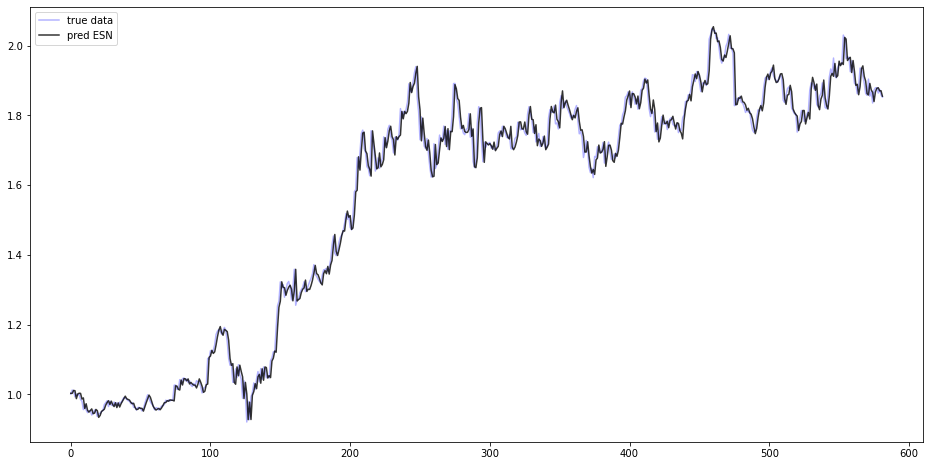

input true_values shape:  (582,)
input pred_values shape:  (582,)
output true_values_abs shape:  (582,)
output pred_values_abs shape:  (582,)


In [28]:
# Re-convert relative change values back to absolute values and plot validation target vs. prediction.
# Note: Use one-step prediction here with "teacher-forcing".
val_target_abs, val_pred_abs = rel_to_abs(val_target, val_pred, target_length=1, verbose=True)

### Optimization of single base ESN

Gridsearch on number of reservoir units (n_res) and input length.

Further parameters:

* work with un-scaled relative change values
* use tanh activation

In [25]:
# Define grid for n_res and input_length.
n_res_grid = [50, 100, 200, 500, 1000]
input_length_grid = [10, 50, 100, 200, 300]

# Set number of runs for each parameter selection.
n_runs = 10

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(n_res_grid), len(input_length_grid), n_runs))
grid_mae = np.zeros((len(n_res_grid), len(input_length_grid), n_runs))

In [27]:
# Note runtime: Start
start = time.time()

# Loop over n_res in n_res_grid:
for i in range(len(n_res_grid)):
    
    # Get current n_res
    n_res = n_res_grid[i]
    
    # Loop over input_length in input_length_grid:
    for j in range(len(input_length_grid)):
        
        # Get current input_length
        input_length = input_length_grid[j]
        
        # Loop over number of runs:
        for run in range(n_runs):
            
            # create rel. change inputs and targets from absolute data
            train_input, val_input, train_target, val_target, train_min, train_max = split_data(data_abs, 
                                                                                    input_length = input_length, 
                                                                                    target_length = 1, 
                                                                                    time_lag=0,
                                                                                    train_val_split=0.8, 
                                                                                    binary_YN=False, 
                                                                                    scaled_YN=False,
                                                                                    verbose=False)

            # Train base ESN.
            # Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
            W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                                          n_res=n_res, 
                                          sparsity=0.2, 
                                          spectral_rad=1.2, 
                                          w_in_lim=1.0, 
                                          activation='tanh', 
                                          verbose=False)

            # Get prediction on validation data and evaluation metrics
            val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                                          activation='tanh',
                                                          scaled_YN=False, 
                                                          train_min=0.0, 
                                                          train_max=0.0, 
                                                          verbose=False)
            
            # Store accuracy and mae for current run for current parameter selection:
            grid_accuracy[i,j,run] = accuracy
            grid_mae[i,j,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

Total runtime:  3834.9356801509857


In [28]:
# Get mean accuracy and mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)

In [29]:
mean_grid_accuracy

array([[0.5019, 0.5052, 0.5038, 0.5009, 0.4936],
       [0.5239, 0.4983, 0.5001, 0.4964, 0.5106],
       [0.5136, 0.5004, 0.49  , 0.5065, 0.5046],
       [0.4988, 0.4994, 0.4955, 0.5012, 0.4994],
       [0.5013, 0.4979, 0.5087, 0.4939, 0.4986]])

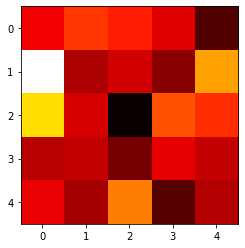

In [31]:
plt.imshow(mean_grid_accuracy, cmap='hot', interpolation='nearest')
plt.show()

In [30]:
mean_grid_mae

array([[0.01382, 0.01394, 0.01529, 0.01421, 0.01438],
       [0.01406, 0.01421, 0.01416, 0.01449, 0.0146 ],
       [0.01478, 0.01457, 0.01477, 0.01483, 0.01643],
       [0.02281, 0.01628, 0.01666, 0.01663, 0.01719],
       [0.07576, 0.01991, 0.0196 , 0.02496, 0.02127]])

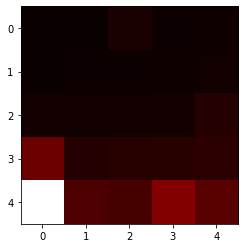

In [32]:
plt.imshow(mean_grid_mae, cmap='hot', interpolation='nearest')
plt.show()

### Optimization of single base ESN

Gridsearch on number of reservoir units (n_res) and input length.

Further parameters:

* work with SCALED relative change values
* use tanh activation

In [33]:
# Define grid for n_res and input_length.
n_res_grid = [50, 100, 200, 500, 1000]
input_length_grid = [10, 50, 100, 200, 300]

# Set number of runs for each parameter selection.
n_runs = 10

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(n_res_grid), len(input_length_grid), n_runs))
grid_mae = np.zeros((len(n_res_grid), len(input_length_grid), n_runs))

In [35]:
# Note runtime: Start
start = time.time()

# Loop over n_res in n_res_grid:
for i in range(len(n_res_grid)):
    
    # Get current n_res
    n_res = n_res_grid[i]
    
    # Loop over input_length in input_length_grid:
    for j in range(len(input_length_grid)):
        
        # Get current input_length
        input_length = input_length_grid[j]
        
        # print status:
        print("n_res_grid: ",i+1," of ", len(n_res_grid))
        print("input_length_grid: ",j+1," of ", len(input_length_grid))
        
        # Loop over number of runs:
        for run in range(n_runs):
            
            # print status:
            print("run: ", run+1, " of ", n_runs)
            
            # create rel. change inputs and targets from absolute data
            train_input, val_input, train_target, val_target, train_min, train_max = split_data(data_abs, 
                                                                                    input_length = input_length, 
                                                                                    target_length = 1, 
                                                                                    time_lag=0,
                                                                                    train_val_split=0.8, 
                                                                                    binary_YN=False, 
                                                                                    scaled_YN=True,
                                                                                    verbose=False)

            # Train base ESN.
            # Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
            W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                                          n_res=n_res, 
                                          sparsity=0.2, 
                                          spectral_rad=1.2, 
                                          w_in_lim=1.0, 
                                          activation='tanh', 
                                          verbose=False)

            # Get prediction on validation data and evaluation metrics
            val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                                          activation='tanh',
                                                          scaled_YN=True, 
                                                          train_min=train_min, 
                                                          train_max=train_max, 
                                                          verbose=False)
            
            # Store accuracy and mae for current run for current parameter selection:
            grid_accuracy[i,j,run] = accuracy
            grid_mae[i,j,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

n_res_grid:  1  of  5
input_length_grid:  1  of  5
run:  1  of  10
run:  2  of  10
run:  3  of  10
run:  4  of  10
run:  5  of  10
run:  6  of  10
run:  7  of  10
run:  8  of  10
run:  9  of  10
run:  10  of  10
n_res_grid:  1  of  5
input_length_grid:  2  of  5
run:  1  of  10
run:  2  of  10
run:  3  of  10
run:  4  of  10
run:  5  of  10
run:  6  of  10
run:  7  of  10
run:  8  of  10
run:  9  of  10
run:  10  of  10
n_res_grid:  1  of  5
input_length_grid:  3  of  5
run:  1  of  10
run:  2  of  10
run:  3  of  10
run:  4  of  10
run:  5  of  10
run:  6  of  10
run:  7  of  10
run:  8  of  10
run:  9  of  10
run:  10  of  10
n_res_grid:  1  of  5
input_length_grid:  4  of  5
run:  1  of  10
run:  2  of  10
run:  3  of  10
run:  4  of  10
run:  5  of  10
run:  6  of  10
run:  7  of  10
run:  8  of  10
run:  9  of  10
run:  10  of  10
n_res_grid:  1  of  5
input_length_grid:  5  of  5
run:  1  of  10
run:  2  of  10
run:  3  of  10
run:  4  of  10
run:  5  of  10
run:  6  of  10
run: 

In [36]:
# Get mean accuracy and mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)

In [37]:
mean_grid_accuracy

array([[0.5246, 0.5144, 0.517 , 0.5095, 0.5036],
       [0.5321, 0.5213, 0.5088, 0.5189, 0.5141],
       [0.5301, 0.5142, 0.5212, 0.5172, 0.5181],
       [0.5091, 0.512 , 0.5192, 0.5086, 0.5065],
       [0.5007, 0.5092, 0.5151, 0.5077, 0.5003]])

In [38]:
mean_grid_mae

array([[0.01372, 0.0139 , 0.01413, 0.01591, 0.01473],
       [0.01384, 0.01405, 0.01414, 0.01436, 0.01457],
       [0.01451, 0.01438, 0.01452, 0.01487, 0.01515],
       [0.02071, 0.0166 , 0.01649, 0.01701, 0.01735],
       [0.05191, 0.02183, 0.0216 , 0.02331, 0.02442]])

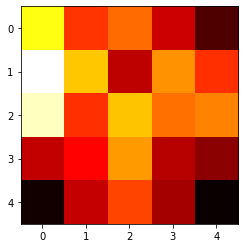

In [39]:
plt.imshow(mean_grid_accuracy, cmap='hot', interpolation='nearest')
plt.show()